In [1]:
#Import nescesary packages

import numpy as np
import pandas as pd
import sklearn 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter
import statistics
import scipy

In [2]:
#import the vehicle dataset from Kaggle
raw_data = pd.read_csv('vehicles.csv')

# Task 1 Identify Features

1. Assemble a dataset consisting of features and target (for example in a dataframe or in two
   arrays X and y). 
2. What features are relevant for the prediction task?
3. Are there any features that should be excluded because they leak the target information?
4. Show visualizations or statistics to support your selection.
5. You are not required to use the description column, but you can try to come up with relevant
   features using it. Please don’t use bag-of-word approaches for now as we’ll discuss these later
   in the class.

1.1 

In [3]:
#subset the data 
raw_data

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,drive,size,type,paint_color,image_url,description,county,state,lat,long
0,7034441763,https://saltlakecity.craigslist.org/cto/d/salt...,salt lake city,https://saltlakecity.craigslist.org,17899,2012.0,volkswagen,golf r,excellent,4 cylinders,...,4wd,compact,hatchback,black,https://images.craigslist.org/00G0G_fTLDWM5Xyv...,PRICE REDUCED! -Garage kept -Low Miles (63K)...,NaN,ut,40.7372,-111.858
1,7034440610,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00v0v_7Cu0buIofU...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
2,7034440588,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,46463,2015.0,gmc,sierra 1500,excellent,NaN,...,4wd,NaN,NaN,white,https://images.craigslist.org/01515_lPvJ9bfbdY...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
3,7034440546,https://saltlakecity.craigslist.org/ctd/d/sand...,salt lake city,https://saltlakecity.craigslist.org,0,2016.0,ford,f-150,excellent,NaN,...,4wd,NaN,NaN,NaN,https://images.craigslist.org/00T0T_6Rjfp3NS4O...,Drive it home today. Call (Or Text) us now !!C...,NaN,ut,40.5881,-111.884
4,7034406932,https://saltlakecity.craigslist.org/ctd/d/evan...,salt lake city,https://saltlakecity.craigslist.org,49999,2018.0,ford,f-450,NaN,NaN,...,4wd,NaN,pickup,white,https://images.craigslist.org/00W0W_8yIUwRBXXd...,2018 Ford F-350 F350 F 350 SD Lariat Crew Cab ...,NaN,ut,40.3744,-104.694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509572,7034554007,https://saltlakecity.craigslist.org/ctd/d/engl...,salt lake city,https://saltlakecity.craigslist.org,15476,2012.0,nissan,xterra,NaN,6 cylinders,...,4wd,NaN,SUV,NaN,https://images.craigslist.org/00z0z_3ERBmVoD5s...,Maximum Auto SearchÂ Â Â Â Â Â Â Â STOCK #:Â Â...,NaN,ut,39.6405,-104.961
509573,7034538385,https://saltlakecity.craigslist.org/ctd/d/engl...,salt lake city,https://saltlakecity.craigslist.org,9881,2008.0,bmw,3 series 328i,NaN,6 cylinders,...,rwd,NaN,convertible,NaN,https://images.craigslist.org/01313_38rMiNAW18...,Maximum Auto SearchÂ Â Â Â Â Â Â Â STOCK #:Â Â...,NaN,ut,39.6405,-104.961
509574,7034523643,https://saltlakecity.craigslist.org/ctd/d/salm...,salt lake city,https://saltlakecity.craigslist.org,24895,2019.0,jeep,cherokee,NaN,4 cylinders,...,4wd,NaN,SUV,white,https://images.craigslist.org/00606_dOtGS5RmTi...,"2019 Jeep Cherokee Latitude Plus -- $24,895 ...",NaN,ut,45.1637,-113.894
509575,7034458858,https://saltlakecity.craigslist.org/cto/d/ogde...,salt lake city,https://saltlakecity.craigslist.org,32500,2017.0,NaN,Porsche Macan GTS,excellent,6 cylinders,...,NaN,NaN,NaN,red,https://images.craigslist.org/00s0s_32yAwr0KMt...,2017 Porsche Macan GTS Carmine Red w/ Black ...,NaN,ut,41.3112,-111.969


In [56]:
# 1.1
target = raw_data['price'] #y
raw_data = raw_data.drop(columns=['price']) #X

1.2 

The features that are relevent to car selling price are 'value adding' features. This can be things such as make and model, number of cyllindars, the odeometer reading, and the year amung many other. Other features that are important to a buyer, such as the vin number, are unique to the car itself. they can be leveraged to gain more information such as the accident history, but by themselves they do not add or remove any value to the car. Therefore, we deciced to drop these values in this setting. 

In [82]:
#1.2, 1.3, 1.5
#Drop county because entire column is NaN
#drop datapoints that are duplicate information
#This informaiton is unique to every single car, and therefore is not a predictive feature
# This column leaks the price (e.g. 2019 Jeep Cherokee Latitude Plus -- $24,895) so it is also dropped
reduced_data = raw_data.drop(columns=['url','region_url', 'image_url','county','vin','id','description']) #url information also shown in a text column


In [83]:
reduced_data

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
0,salt lake city,2012.0,volkswagen,golf r,excellent,4 cylinders,gas,63500.0,clean,manual,4wd,compact,hatchback,black,ut,40.7372,-111.858
1,salt lake city,2016.0,ford,f-150,excellent,NaN,gas,10.0,clean,automatic,4wd,NaN,NaN,NaN,ut,40.5881,-111.884
2,salt lake city,2015.0,gmc,sierra 1500,excellent,NaN,gas,7554.0,clean,automatic,4wd,NaN,NaN,white,ut,40.5881,-111.884
3,salt lake city,2016.0,ford,f-150,excellent,NaN,gas,10.0,clean,automatic,4wd,NaN,NaN,NaN,ut,40.5881,-111.884
4,salt lake city,2018.0,ford,f-450,NaN,NaN,diesel,70150.0,clean,automatic,4wd,NaN,pickup,white,ut,40.3744,-104.694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
509572,salt lake city,2012.0,nissan,xterra,NaN,6 cylinders,gas,103135.0,clean,automatic,4wd,NaN,SUV,NaN,ut,39.6405,-104.961
509573,salt lake city,2008.0,bmw,3 series 328i,NaN,6 cylinders,gas,108277.0,clean,automatic,rwd,NaN,convertible,NaN,ut,39.6405,-104.961
509574,salt lake city,2019.0,jeep,cherokee,NaN,4 cylinders,gas,6973.0,clean,automatic,4wd,NaN,SUV,white,ut,45.1637,-113.894
509575,salt lake city,2017.0,NaN,Porsche Macan GTS,excellent,6 cylinders,gas,37520.0,clean,automatic,NaN,NaN,NaN,red,ut,41.3112,-111.969


In [84]:
# split training and test data so that scaling & median imputing strategy does not leak data 

X_train, X_test, y_train, y_test = train_test_split(reduced_data, target, shuffle=True, random_state=0)

In [85]:
#sort variables into continuous and categorical
continuous = []
categorical = []
for column in reduced_data.columns:
    if reduced_data[column].dtype == 'float':
        continuous.append(column)
    else:
        categorical.append(column)

# Initial Feature Engineering 

In [7]:
def most_frequent(column):
    array = np.asarray(reduced_data[column])
    counter = Counter(array)
    return counter.most_common

In [ ]:
most_frequent('cylinders')

In [ ]:
most_frequent('drive')

In [ ]:
most_frequent('title_status')

In [ ]:
most_frequent('state')

In [ ]:
most_frequent('manufacturer')

In [ ]:
most_frequent('size')

In [ ]:
most_frequent('paint_color')

In [72]:
#replace Nan values with wither median (continuous) or most frequent (categorical)

continuous_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

In [86]:
nan_list = X_train.columns[X_train.isna().any()].to_list()

In [87]:
# cat = [x for x in some_list if x in some_other_list]
cat = [col for col in categorical if col in nan_list]
con = [col for col in continuous if col in nan_list]

In [88]:
X_train[con]

,year,odometer,lat,long
323913,2012.0,88600.0,46.5825,-113.2090
123671,2007.0,159000.0,38.6093,-121.4440
157650,2008.0,NaN,26.5677,-81.5954
156849,2004.0,194000.0,29.2833,-81.0882
4749,1997.0,185467.0,36.6218,-79.4124
...,...,...,...,...
439107,2007.0,128000.0,40.1134,-76.5185
117952,2006.0,89152.0,35.1222,-120.6260
435829,2008.0,132811.0,41.5700,-81.5747
305711,2006.0,NaN,45.7281,-94.9682


In [89]:
X_train[con] = continuous_imputer.fit_transform(X_train[con])
X_train[cat] = categorical_imputer.fit_transform(X_train[cat])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

In [90]:
X_train

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,lat,long
323913,missoula,2012.0,ford,f350 super duty,excellent,6 cylinders,diesel,88600.0,lien,automatic,4wd,full-size,truck,white,mt,46.5825,-113.2090
123671,stockton,2007.0,mercedes-benz,benz gl-450,excellent,6 cylinders,gas,159000.0,clean,automatic,4wd,full-size,SUV,black,ca,38.6093,-121.4440
157650,ft myers / SW florida,2008.0,ram,f-150,excellent,6 cylinders,diesel,94801.0,clean,manual,4wd,full-size,sedan,white,fl,26.5677,-81.5954
156849,daytona beach,2004.0,bmw,530i,good,6 cylinders,gas,194000.0,clean,automatic,rwd,full-size,sedan,blue,fl,29.2833,-81.0882
4749,danville,1997.0,ford,f150 4x4,like new,8 cylinders,gas,185467.0,clean,automatic,4wd,full-size,truck,red,va,36.6218,-79.4124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439107,lancaster,2007.0,chevrolet,tahoe,excellent,8 cylinders,gas,128000.0,clean,automatic,4wd,full-size,SUV,blue,pa,40.1134,-76.5185
117952,san luis obispo,2006.0,chevrolet,corvette,excellent,6 cylinders,gas,89152.0,clean,automatic,rwd,full-size,sedan,white,ca,35.1222,-120.6260
435829,erie,2008.0,chevrolet,colorado,excellent,6 cylinders,gas,132811.0,clean,automatic,fwd,full-size,pickup,black,pa,41.5700,-81.5747
305711,st cloud,2006.0,chrysler,300 touring,fair,6 cylinders,gas,94801.0,clean,automatic,rwd,full-size,sedan,silver,mn,45.7281,-94.9682


In [107]:
y_train

323913        0
123671     8000
157650    14900
156849     2300
4749       6850
          ...  
439107     9995
117952    16995
435829     8995
305711     2995
461484     8980
Name: price, Length: 382182, dtype: int64

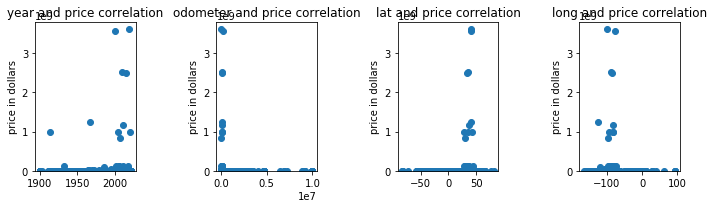

In [166]:
fig1, ax = plt.subplots(1,4,figsize=(10,3))
i=0
for col in X_train[con]:
    ax[i].scatter(X_train[col], y_train)
    ax[i].set_ylabel('price in dollars')
    ax[i].set_title(f'{col} and price correlation')
fig1.tight_layout()

#log transforms of price 

In [151]:
#Pearson coefficient between price and the column 
for col in X_train[con]:
    r = scipy.stats.pearsonr(X_train[col],y_train)
    print(f'the correlation value is {r[1]} for price and {col}')

the correlation value is 0.012433075029088523 for price and year
the correlation value is 0.7047691816352786 for price and odometer
the correlation value is 0.5955484560771267 for price and lat
the correlation value is 0.5945744428437922 for price and long


In [161]:
len([x for x in y_train if x>0])

349521

# Airing of the Greivances 

        1. can we train test split at the v ery beginning because we have to impute at the beginning to remove NaN and dont want to add bias
    Task 1
    1. it says to show images and decisions for features that we dropped, but we did these based on logic. what do we show? Can we jsut show NaN or uniqueness 
    2. For the data that we did keep, do we jsut show the pearson correlation values for continuous and chi squared for categorical
    3. what happens if all of those vales are bad?
    Task 2
    1. whatever we initially decide is important- we go forward and do an initial score on these?

# Responses 

1a. artificially creating a cross val set so that you can. Impute and do pre-processing and THEN do train test split. As long as the test data is not specefied, we can impute with median. also be ok to replace test data with training median. 
Task1 
1. the scatter plots are good for this, just clean them up. There is not a good way to do this for categorical, just do histagrams to show how the classes are distributed over the prediction. categories relate to predictions. 
2. correlation is good for the continuous, show min&max to show that they make sense; fo rcategorical chai squared is good. Look at things from slides. Show distribution of categories in a class. 
3. this is not conclusive. this is a naiive way to think aobut things. Multi-colinearity could show these relationships. Include variables that showed good promise in the visualizations. 
Task 2
1. do this based off whatever you chose from task 1. I am in a hurry to create a model, you need results quickly and just want the minimum viable model to dump into Sci-Kit learn (in the right format with matricies) e.g. encode the features and scale, etc. 